In [ ]:
import glob
import os
import json
import re

folder_path = "../../data/evaluation"
json_files = glob.glob(os.path.join(folder_path, "*.json"))

puzzle_ids = []

train_data = {}
test_inputs = {}
test_outputs = {}

for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        puzzle_id = re.search(r"([\da-f]+)\.json$", file).group(1)

        puzzle_ids.append(puzzle_id)
        train_data[puzzle_id] = data["train"]
        test_inputs[puzzle_id] = data["test"][0]['input']

        test_outputs[puzzle_id] = data["test"][0]['output']

/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_8162/3376240915.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_clusters)


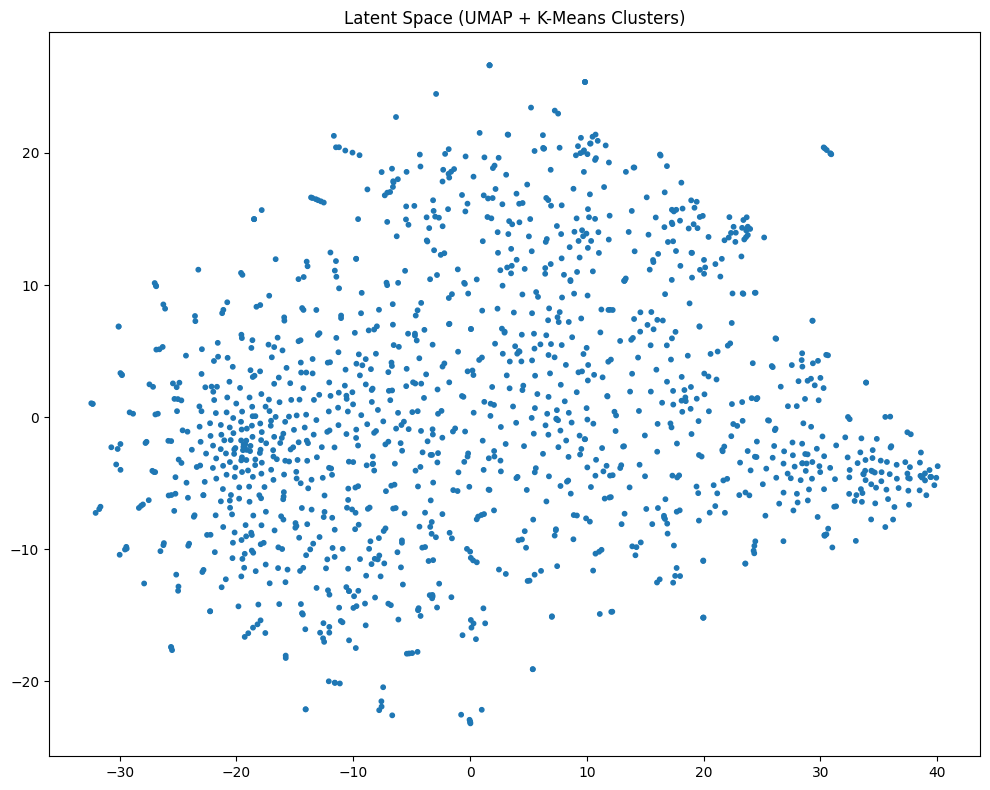

In [14]:
import torch
import hdbscan
import numpy as np
import umap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from data.scale_processing import scaling


def normalize_fn(x, hw):
        h, w = hw
        # Normalize the grid to the target size
        return scaling(x, height=h, width=w, direction='norm')

X = np.array([normalize_fn(np.array(pair['input']), (30,30)) for puzzle_id in puzzle_ids for pair in train_data[puzzle_id]])
X = X.reshape(X.shape[0], -1)
X_scaled = StandardScaler().fit_transform(X)

# labels = KMeans(n_clusters=5).fit_predict(X_scaled)
labels = GaussianMixture(n_components=1).fit_predict(X_scaled)
# labels = DBSCAN(eps=2, min_samples=5).fit_predict(X_scaled)
# labels = hdbscan.HDBSCAN(min_cluster_size=5).fit_predict(X_scaled)

# reducer = umap.UMAP(n_components=2, random_state=42)
# latent_2d = reducer.fit_transform(z_scaled)  # shape: [2*N, 2]

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(X_scaled)

# Create colors from labels
num_clusters = len(np.unique(labels))
cmap = cm.get_cmap('tab10', num_clusters)
colors = [cmap(l) for l in labels]

# Plot all points together
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=10)
plt.title("Latent Space (UMAP + K-Means Clusters)")
plt.tight_layout()
plt.show()

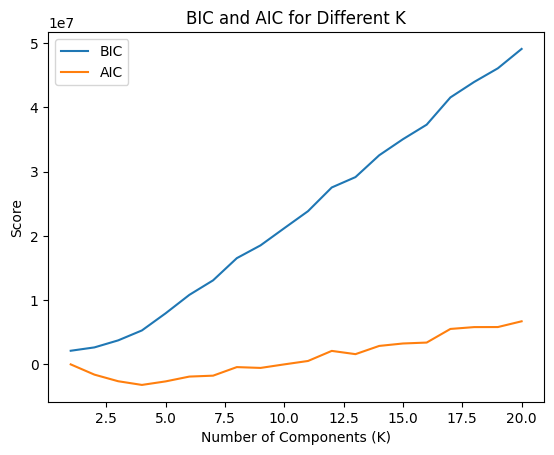

Best K according to BIC: 1
Best K according to AIC: 4


In [15]:
bic_scores = []
aic_scores = []
n_components_range = range(1, 21)  # Test for K = 1 to 20

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

plt.plot(n_components_range, bic_scores, label='BIC')
plt.plot(n_components_range, aic_scores, label='AIC')
plt.xlabel('Number of Components (K)')
plt.ylabel('Score')
plt.legend()
plt.title('BIC and AIC for Different K')
plt.show()

# Find the best K
best_k_bic = np.argmin(bic_scores) + 1
best_k_aic = np.argmin(aic_scores) + 1

print(f"Best K according to BIC: {best_k_bic}")
print(f"Best K according to AIC: {best_k_aic}")

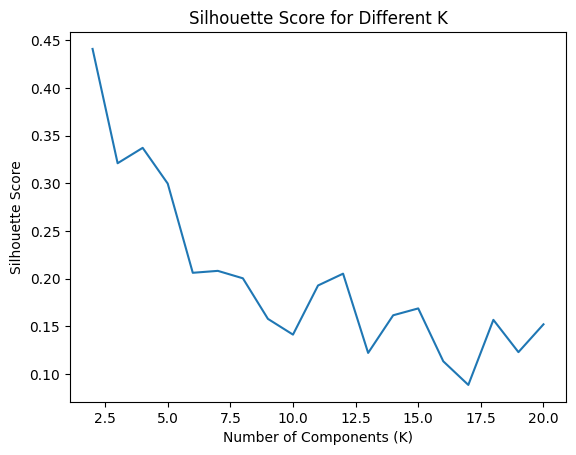

Best K according to Silhouette Score: 2


In [16]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

sil_scores = []

for n_components in range(2, 21):  # Start from 2 as silhouette doesn't work for 1 cluster
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)  # Get cluster labels
    sil_score = silhouette_score(X_scaled, labels)
    sil_scores.append(sil_score)

# Plot Silhouette Score
plt.plot(range(2, 21), sil_scores)
plt.xlabel('Number of Components (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K')
plt.show()

# Find the best K
best_k_sil = np.argmax(sil_scores) + 2  # Indexing starts at 2
print(f"Best K according to Silhouette Score: {best_k_sil}")

K=2, Average Silhouette Score: 0.3401
K=3, Average Silhouette Score: 0.2200
K=4, Average Silhouette Score: 0.2348
K=5, Average Silhouette Score: 0.2439
K=6, Average Silhouette Score: 0.1942
K=7, Average Silhouette Score: 0.1929
K=8, Average Silhouette Score: 0.1361
K=9, Average Silhouette Score: 0.0787
K=10, Average Silhouette Score: -0.1192
K=11, Average Silhouette Score: -0.0915
K=12, Average Silhouette Score: -0.0624
K=13, Average Silhouette Score: -0.0989
K=14, Average Silhouette Score: -0.0378
K=15, Average Silhouette Score: -0.2237
K=16, Average Silhouette Score: -0.0859
K=17, Average Silhouette Score: -0.1691
K=18, Average Silhouette Score: -0.1132
K=19, Average Silhouette Score: -0.0984
K=20, Average Silhouette Score: -0.0845


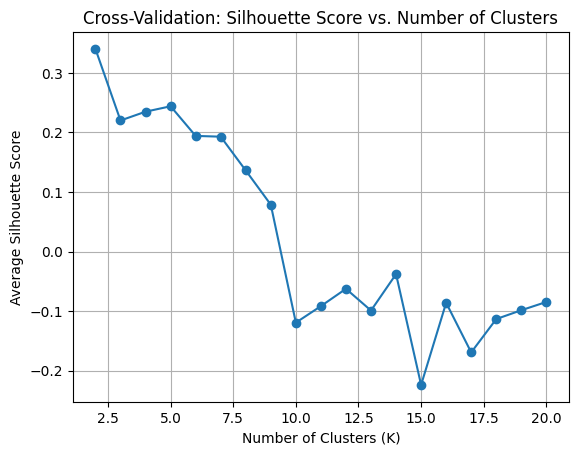

Best K (based on silhouette score): 2


In [17]:
from sklearn.model_selection import KFold

def cross_val_clustering(X, n_clusters_range, n_splits=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results = {}

    for n_clusters in n_clusters_range:
        sil_scores = []
        
        for train_index, val_index in kf.split(X_scaled):
            X_train, X_val = X_scaled[train_index], X_scaled[val_index]
            
            gmm = GaussianMixture(n_components=n_clusters)
            gmm.fit(X_train)
            
            labels = gmm.predict(X_val)
            
            sil_score = silhouette_score(X_val, labels)
            sil_scores.append(sil_score)
        
        results[n_clusters] = np.mean(sil_scores)
    
    return results

n_clusters_range = range(2, 21)  # Test for K = 2 to 20

# Run the cross-validation function
results = cross_val_clustering(X, n_clusters_range)

# Print the results (average silhouette score for each K)
for k, score in results.items():
    print(f"K={k}, Average Silhouette Score: {score:.4f}")

# Plot the results to visualize the best K
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('Cross-Validation: Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Identify the best K based on the highest silhouette score
best_k = max(results, key=results.get)
print(f"Best K (based on silhouette score): {best_k}")